In [1]:
from astropy.io import fits
import numpy as np
import glob
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
import os
import matplotlib.pyplot as plt
from astropy.table import hstack, vstack, Table
from astropy.time import Time
import pdb
%matplotlib inline

In [2]:
#for file in fileList:
def get_slope_img(file,slopeType='Last - First'):
    HDU = fits.open(file)
    data = HDU[0].data
    header = HDU[0].header
    if slopeType == 'Last - First':
        diff = data[-1,:,:] - data[0,:,:]
        time = header['INTTIME'] - header['TGROUP']
        slp = diff / time
    elif slopeType == 'Slope File':
        slp = data[0,:,:]
    else:
        print('Invalid Slope Type')
        slp = np.array(0)
    HDU.close()
    return slp, header

def do_phot(fileName,apPos,r_src=70,r_in=72,r_out=80,showPlot=False,slopeType='Last - First'):
    img, header = get_slope_img(fileName,slopeType=slopeType)
    apUse = apPos - np.array([header['COLCORNR'],header['ROWCORNR']])
    apSource = CircularAperture(apUse,r_src)
    apBack = CircularAnnulus(apUse,r_in=r_in,r_out=r_out)
    
    ## Do the photometry
    mask = np.isnan(img)
    photTable = aperture_photometry(img, apSource,mask=mask)
    backTable = aperture_photometry(img, apBack,mask=mask)
    photTable = hstack([photTable, backTable], table_names=['raw', 'bkg'])
    photTable['resid_sum'] = (photTable['aperture_sum_raw'] - 
                              photTable['aperture_sum_bkg'] * apSource.area() / apBack.area())
    photTable['file name'] = os.path.basename(fileName)

    ## Find the time
    timeRel = (header['ON_NINT'] * (header['INTTIME']+header['TGROUP']))/(24. * 3600.)
    timeRef = Time(header['DATE-OBS']+'T'+header['TIME-OBS']).jd
    tstart = timeRel + timeRef
    photTable['time-start'] = tstart
    
    ## Plot
    if showPlot:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(img)
        apSource.plot(ax=ax,color='white',linewidth=3)
        apBack.plot(ax=ax,color='yellow',linewidth=3)
        ax.set_xlim(apUse[0] - r_out - 30, apUse[0] + r_out + 30)
        ax.set_ylim(apUse[1] - r_out - 30, apUse[1] + r_out + 30)
    
    return photTable['aperture_sum_raw','resid_sum','aperture_sum_bkg','file name','time-start']

def get_file_table(testDirectories,fileType='.red'):
    fileList, testList, slopeTypeList = [], [], []
    ## Ignore this test since these files were corrupted
    badDirectory = '_2016-01-12T17h09m18'
    for testDir in testDirectories:
        if badDirectory not in testDir:
            testName = os.path.basename(testDir).split('-')[0].split('NRCN821')[-1]
            if fileType == 'slp/red':
                if 'SUB' in testName:
                    useFileType = '.slp'
                    SlopeType = 'Slope File'
                else:
                    useFileType = '.red'
                    SlopeType = 'Last - First'
            else:
                useFileType = fileType
                SlopeType = 'Last - First'

            fileSearchShort = testDir+'/*I50'+useFileType+'.fits'
            fileSearchLong = testDir+'/*I050'+useFileType+'.fits'


            for search in [fileSearchLong,fileSearchShort]:
                newFiles = glob.glob(search)

                fileList = fileList + newFiles
                testList = testList + [testName] * len(newFiles)
                slopeTypeList = slopeTypeList + [SlopeType] * len(newFiles)
    fileTable = Table()
    fileTable['Full Path'] = fileList
    fileTable['Test Name'] = testList
    fileTable['Slope Type'] = slopeTypeList
    return fileTable

def get_phot_table(fileTable,apPos=[1408,1041],r_src=70,r_in=72,r_out=80):
    t = Table()
    for file in fileTable:
        phot_table = do_phot(file['Full Path'],apPos,r_src=r_src,r_in=r_in,r_out=r_out,
                             slopeType=file['Slope Type'])
        phot_table['Test Name'] = file['Test Name']
        t = vstack([phot_table,t])

    fluxRef = np.nanmedian(t['resid_sum'])
    t['norm_flux'] = t['resid_sum'] / fluxRef
    return t

def plot_long_series(t,fileType,ax=None,fig=None):
    if fig == None:
        fig, ax = plt.subplots(figsize=(15,5))
    uniqTest = np.unique(fileTable['Test Name'])
    for test in uniqTest:
        testp = t['Test Name'] == test
        x = t['time-start'][testp]
        y = t['norm_flux'][testp]
        ax.plot(x,y,'o')
        ax.text(np.nanmean(x),np.nanmin(y) - 1e-3,test,horizontalalignment='center',verticalalignment='top')
    ax.set_title('Using '+fileType+' files')
    ax.set_xlabel('Time (JD)')
    ax.set_ylabel('Normalized Flux')

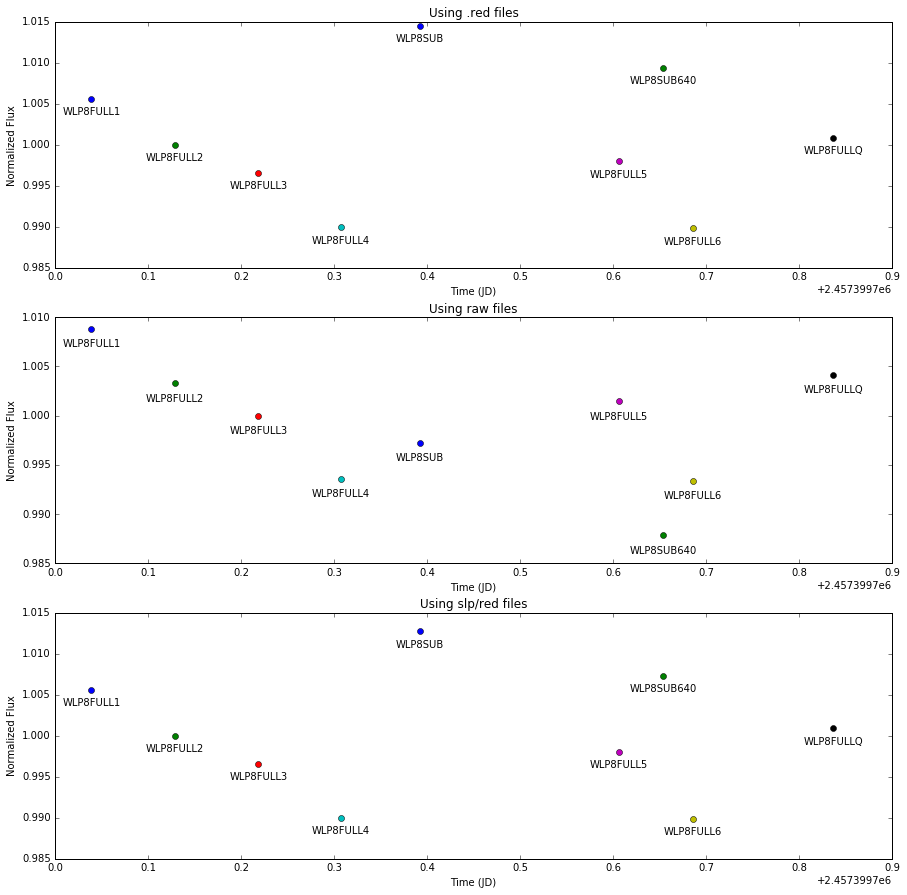

In [3]:
prefix = '/data1/tso_analysis/all_tso_cv3/raw_separated_PPP/'
testDirectories = glob.glob(prefix + 'NRCN821WLP8*_481_*')

fig, ax = plt.subplots(3,1,figsize=(15,15))
fileTypes=['.red','','slp/red']
fileTypeNames = ['.red','raw','slp/red']
for ind, fileType in enumerate(fileTypes):
    fileTable = get_file_table(testDirectories,fileType=fileType)
    t = get_phot_table(fileTable)
    plot_long_series(t,fileTypeNames[ind],ax=ax[ind],fig=fig)

In [4]:
fig.savefig('plots/red_slope_raw_series.pdf')

IOError: [Errno 2] No such file or directory: 'plots/red_slope_raw_series.pdf'